In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import datasets
from self_supervised_tasks import *
from predictive_models import *

from utils import (
    compute_interval_metrics,
    compute_deficet,
    compute_excess,
    process_results,
    write_to_file,
)

import logging
logging.getLogger().setLevel(logging.INFO)

# GET DATASET

In [2]:
seed=42
dataset_name='facebook_2'
# load the dataset
X, y = datasets.GetDataset(dataset_name, "../datasets/")

In [3]:
alpha = 0.1

# Preprocess data
(
    X_train_sc,
    X_residual_sc,
    X_cal_sc,
    X_test_sc,
    y_train_sc,
    y_residual_sc,
    y_cal_sc,
    y_test_sc,
) = datasets.process_data(X=X, y=y, seed=seed)

(41630, 53) (13010, 53) (10408, 53) (16263, 53) (81311, 53)


# STEP 1: FIT PREDICTIVE MODEL 

In [4]:
epochs = 500
batch_size = 128

pred_model = predictive_model(
            input_shape=X_train_sc.shape[1],
            epochs=epochs,
            batch_size=batch_size,
            seed=seed,
        )
pred_model.fit(X_train_sc, y_train_sc)

Epoch 1/500


2023-02-14 22:13:36.492805: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


326/326 [==============================] - 1s 2ms/step - loss: 19.1190
Epoch 2/500
326/326 [==============================] - 1s 2ms/step - loss: 16.8900
Epoch 3/500
326/326 [==============================] - 1s 2ms/step - loss: 16.0556
Epoch 4/500
326/326 [==============================] - 1s 2ms/step - loss: 15.8234
Epoch 5/500
326/326 [==============================] - 1s 2ms/step - loss: 14.5008
Epoch 6/500
326/326 [==============================] - 1s 2ms/step - loss: 14.6089
Epoch 7/500
326/326 [==============================] - 1s 2ms/step - loss: 14.1652
Epoch 8/500
326/326 [==============================] - 1s 2ms/step - loss: 13.6437
Epoch 9/500
326/326 [==============================] - 1s 2ms/step - loss: 13.4764
Epoch 10/500
326/326 [==============================] - 1s 2ms/step - loss: 12.8239
Epoch 11/500
326/326 [==============================] - 1s 2ms/step - loss: 12.6245
Epoch 12/500
326/326 [==============================] - 1s 2ms/step - loss: 12.3439
Epoch 13/500


# STEP 2: FIT SSL MODEL ON EMBEDDING OF PREDICTIVE MODEL

## 2.1 AUTOENCODER

In [5]:
ssl_task = AutoEncoder(
            input_shape=pred_model.extract_encoding(X_train_sc).shape[1],
            reconstruct_shape=X_train_sc.shape[1],
            epochs=epochs,
            batch_size=batch_size,
            seed=seed,
        )
ssl_task.fit(x_train=X_train_sc, pred_model=pred_model)

Epoch 1/500
326/326 [==============================] - 1s 2ms/step - loss: 0.5307
Epoch 2/500
326/326 [==============================] - 1s 2ms/step - loss: 0.2900
Epoch 3/500
326/326 [==============================] - 1s 2ms/step - loss: 0.2150
Epoch 4/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1885
Epoch 5/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1739
Epoch 6/500
326/326 [==============================] - 0s 1ms/step - loss: 0.1539
Epoch 7/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1431
Epoch 8/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1391
Epoch 9/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1424
Epoch 10/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1308
Epoch 11/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1224
Epoch 12/500
326/326 [==============================] - 1s 2ms/step - loss: 0.1117
Epoch 13/500


# 2.2 VIME

In [6]:
vime = Vime_Task(epochs=epochs, seed=seed)
vime.fit(pred_model.extract_encoding(X_train_sc))

Epoch 1/500
326/326 [==============================] - 1s 2ms/step - loss: 5.6385 - mask_loss: 0.3459 - feature_loss: 2.6463
Epoch 2/500
326/326 [==============================] - 1s 2ms/step - loss: 5.4947 - mask_loss: 0.3111 - feature_loss: 2.5918
Epoch 3/500
326/326 [==============================] - 1s 2ms/step - loss: 5.4824 - mask_loss: 0.3061 - feature_loss: 2.5881
Epoch 4/500
326/326 [==============================] - 1s 2ms/step - loss: 5.4743 - mask_loss: 0.3019 - feature_loss: 2.5862
Epoch 5/500
326/326 [==============================] - 1s 2ms/step - loss: 5.4680 - mask_loss: 0.2979 - feature_loss: 2.5851
Epoch 6/500
326/326 [==============================] - 1s 2ms/step - loss: 5.4624 - mask_loss: 0.2939 - feature_loss: 2.5842
Epoch 7/500
326/326 [==============================] - 0s 2ms/step - loss: 5.4571 - mask_loss: 0.2899 - feature_loss: 2.5836
Epoch 8/500
326/326 [==============================] - 1s 2ms/step - loss: 5.4523 - mask_loss: 0.2860 - feature_loss: 2.5832


# STEP 3: RUN VARIANTS ADAPTING WITH RESIDUALS

In [ ]:
from sklearn.ensemble import RandomForestRegressor

cfr_results_list = []
results = {}

alpha=0.1

logging.info('Running vanilla ICP')

# predict on calibration set and test set
ypred_cal=pred_model.predict(X_cal_sc).reshape(-1,1)
ypred_test=pred_model.predict(X_test_sc).reshape(-1,1)

N=len(y_cal_sc)

# compute main model errors
main_model_errors = ypred_test - y_test_sc

/Users/nabeel/Documents/Projects/Noise/code/venv3.7/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/Users/nabeel/Documents/Projects/Noise/code/venv3.7/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/

# 3.2: CFR

In [ ]:
logging.info('Running conformalized residual fitting')
#calculate residuals
res_y=np.abs(y_residual_sc-pred_model.predict(X_residual_sc).reshape(-1,1))
res_y += 0.00001 # prevent log(0)
res_y = np.log(res_y)

# fit residual model
epochs=500
model_r = predictive_model(
    input_shape= X_residual_sc.shape[1],
    epochs=epochs,
    batch_size=128,
)
model_r.fit(X_residual_sc,res_y)

#calculate q_yhat for the calibration set
res_ypred_cal=model_r.predict(X_cal_sc).reshape(-1,1)
res_ypred_cal = np.exp(res_ypred_cal)
q_yhat=np.quantile(np.abs(y_cal_sc-ypred_cal)/res_ypred_cal,np.ceil((N+1)*(1-alpha))/N)

#predict with 1-alpha confidence - scaled by residual predictions
res_ypred_test=model_r.predict(X_test_sc).reshape(-1,1)
res_ypred_test= np.exp(res_ypred_test)
lower_bound=ypred_test-(q_yhat*res_ypred_test.reshape(-1,1))
upper_bound=ypred_test+(q_yhat*res_ypred_test.reshape(-1,1))

cfr_residual_model_errors =res_ypred_test

cfr_upper = upper_bound
cfr_lower = lower_bound

coverage, avg_length = compute_interval_metrics(lower_bound,upper_bound,y_test_sc)
avg_excess, proportion_excess = compute_excess(lower_bound,upper_bound,y_test_sc)
avg_deficet, proportion_deficet = compute_deficet(lower_bound,upper_bound,y_test_sc)

results['CFR'] = {'avg_length': avg_length, 'avg_excess': avg_excess, 'avg_deficet': avg_deficet, 'coverage':coverage}
results['CFR']

INFO:root:Running conformalized residual fitting


Epoch 1/500
102/102 [==============================] - 1s 2ms/step - loss: 2.3177
Epoch 2/500
102/102 [==============================] - 0s 2ms/step - loss: 1.2982
Epoch 3/500
102/102 [==============================] - 0s 2ms/step - loss: 1.1812
Epoch 4/500
102/102 [==============================] - 0s 2ms/step - loss: 1.1441
Epoch 5/500
102/102 [==============================] - 0s 2ms/step - loss: 1.1002
Epoch 6/500
102/102 [==============================] - 0s 2ms/step - loss: 1.0668
Epoch 7/500
102/102 [==============================] - 0s 2ms/step - loss: 1.0443
Epoch 8/500
102/102 [==============================] - 0s 3ms/step - loss: 1.0269
Epoch 9/500
102/102 [==============================] - 0s 2ms/step - loss: 1.0081
Epoch 10/500
102/102 [==============================] - 0s 2ms/step - loss: 1.0111
Epoch 11/500
102/102 [==============================] - 0s 2ms/step - loss: 0.9840
Epoch 12/500
102/102 [==============================] - 0s 2ms/step - loss: 0.9817
Epoch 13/500


{'avg_length': 2.001012,
 'avg_excess': 0.6124135,
 'avg_deficet': 2.280961,
 'coverage': 89.81122794072435}

# 3.3 CFR + AE

In [ ]:

logging.info('AE SSL Running SSL conformalized residual fitting')

#fit a new model to predict residuals - augmented with SSL task 

# predict with SSL task
ssl_train = ssl_task.predict(X_train_sc).reshape(-1,1)
ssl_residual = ssl_task.predict(X_residual_sc).reshape(-1,1)
ssl_cal = ssl_task.predict(X_cal_sc).reshape(-1,1)
ssl_test = ssl_task.predict(X_test_sc).reshape(-1,1)

# Scale
scaler_ssl = StandardScaler()
scaler_ssl.fit(ssl_train)

ssl_train_sc_ae = scaler_ssl.transform(ssl_train)
ssl_residual_sc_ae = scaler_ssl.transform(ssl_residual)
ssl_cal_sc_ae= scaler_ssl.transform(ssl_cal)
ssl_test_sc_ae = scaler_ssl.transform(ssl_test)

res_y=np.abs(y_residual_sc-pred_model.predict(X_residual_sc).reshape(-1,1))
X_train_r  = np.hstack([X_residual_sc, ssl_residual_sc_ae])

#fit a new model to predict residuals
epochs=500
model_r = predictive_model(
    input_shape= X_train_r.shape[1],
    epochs=epochs,
    batch_size=128,
)
model_r.fit(X_train_r,res_y)


#calculate q_yhat for the calibration set
X_cal_r  = np.hstack([X_cal_sc, ssl_cal_sc_ae])
res_ypred_cal=model_r.predict(X_cal_r).reshape(-1,1)
q_yhat=np.quantile(np.abs(y_cal_sc-ypred_cal)/res_ypred_cal,np.ceil((N+1)*(1-alpha))/N)

#predict with 1-alpha confidence - scaled by residual predictions
X_test_r  = np.hstack([X_test_sc, ssl_test_sc_ae])
res_ypred_test=model_r.predict(X_test_r).reshape(-1,1)
lower_bound=ypred_test-(q_yhat*res_ypred_test.reshape(-1,1))
upper_bound=ypred_test+(q_yhat*res_ypred_test.reshape(-1,1))

ae_residual_model_errors =res_ypred_test

ae_upper = upper_bound
ae_lower = lower_bound

coverage, avg_length = compute_interval_metrics(lower_bound,upper_bound,y_test_sc)
avg_excess, proportion_excess = compute_excess(lower_bound,upper_bound,y_test_sc)
avg_deficet, proportion_deficet = compute_deficet(lower_bound,upper_bound,y_test_sc)


results['CFR+AE'] = {'avg_length': avg_length, 'avg_excess': avg_excess, 'avg_deficet': avg_deficet, 'coverage':coverage}


INFO:root:AE SSL Running SSL conformalized residual fitting


Epoch 1/500
102/102 [==============================] - 1s 2ms/step - loss: 9.4885
Epoch 2/500
102/102 [==============================] - 0s 2ms/step - loss: 8.6023
Epoch 3/500
102/102 [==============================] - 0s 2ms/step - loss: 8.0161
Epoch 4/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7438
Epoch 5/500
102/102 [==============================] - 0s 2ms/step - loss: 7.8122
Epoch 6/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7352
Epoch 7/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7092
Epoch 8/500
102/102 [==============================] - 0s 2ms/step - loss: 7.1437
Epoch 9/500
102/102 [==============================] - 0s 2ms/step - loss: 7.1878
Epoch 10/500
102/102 [==============================] - 0s 2ms/step - loss: 7.2239
Epoch 11/500
102/102 [==============================] - 0s 2ms/step - loss: 7.2042
Epoch 12/500
102/102 [==============================] - 0s 2ms/step - loss: 7.1051
Epoch 13/500


# 3.4: CFR + VIME

In [ ]:


logging.info('VIME SSL Running SSL conformalized residual fitting')

#fit a new model to predict residuals - augmented with SSL task 

# predict with VIME
ssl_train = vime.predict(pred_model.extract_encoding(X_train_sc)).reshape(-1,1)
ssl_residual = vime.predict(pred_model.extract_encoding(X_residual_sc)).reshape(-1,1)
ssl_cal = vime.predict(pred_model.extract_encoding(X_cal_sc)).reshape(-1,1)
ssl_test = vime.predict(pred_model.extract_encoding(X_test_sc)).reshape(-1,1)

# scale
scaler_ssl = StandardScaler()
scaler_ssl.fit(ssl_train)

ssl_train_sc_vime = scaler_ssl.transform(ssl_train)
ssl_residual_sc_vime = scaler_ssl.transform(ssl_residual)
ssl_cal_sc_vime = scaler_ssl.transform(ssl_cal)
ssl_test_sc_vime = scaler_ssl.transform(ssl_test)

res_y=np.abs(y_residual_sc-pred_model.predict(X_residual_sc).reshape(-1,1))

X_train_r  = np.hstack([X_residual_sc, ssl_residual_sc_vime])

#fit a new model to predict residuals
epochs=500
model_r = predictive_model(
    input_shape= X_train_r.shape[1],
    epochs=epochs,
    batch_size=128,
)
model_r.fit(X_train_r,res_y)


#calculate q_yhat for the calibration set
X_cal_r  = np.hstack([X_cal_sc, ssl_cal_sc_vime])
res_ypred_cal=model_r.predict(X_cal_r).reshape(-1,1)
q_yhat=np.quantile(np.abs(y_cal_sc-ypred_cal)/res_ypred_cal,np.ceil((N+1)*(1-alpha))/N)

#predict with 1-alpha confidence - scaled by residual predictions
X_test_r  = np.hstack([X_test_sc, ssl_test_sc_vime])
res_ypred_test=model_r.predict(X_test_r).reshape(-1,1)
lower_bound=ypred_test-(q_yhat*res_ypred_test.reshape(-1,1))
upper_bound=ypred_test+(q_yhat*res_ypred_test.reshape(-1,1))

vime_residual_model_errors =res_ypred_test


vime_upper = upper_bound
vime_lower = lower_bound

coverage, avg_length = compute_interval_metrics(lower_bound,upper_bound,y_test_sc)
avg_excess, proportion_excess = compute_excess(lower_bound,upper_bound,y_test_sc)
avg_deficet, proportion_deficet = compute_deficet(lower_bound,upper_bound,y_test_sc)


results['CFR+VIME'] = {'avg_length': avg_length, 'avg_excess': avg_excess, 'avg_deficet': avg_deficet, 'coverage':coverage}




INFO:root:VIME SSL Running SSL conformalized residual fitting


Epoch 1/500
102/102 [==============================] - 1s 2ms/step - loss: 9.5221
Epoch 2/500
102/102 [==============================] - 0s 2ms/step - loss: 8.6799
Epoch 3/500
102/102 [==============================] - 0s 2ms/step - loss: 8.1668
Epoch 4/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7506
Epoch 5/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7890
Epoch 6/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7440
Epoch 7/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7266
Epoch 8/500
102/102 [==============================] - 0s 2ms/step - loss: 7.2666
Epoch 9/500
102/102 [==============================] - 0s 2ms/step - loss: 7.2587
Epoch 10/500
102/102 [==============================] - 0s 2ms/step - loss: 7.4449
Epoch 11/500
102/102 [==============================] - 0s 2ms/step - loss: 7.1841
Epoch 12/500
102/102 [==============================] - 0s 2ms/step - loss: 7.1850
Epoch 13/500


# ANALYZE

In [ ]:
cfr_results_list.append(results)
cfr_results_list

[{'CFR': {'avg_length': 2.001012,
   'avg_excess': 0.6124135,
   'avg_deficet': 2.280961,
   'coverage': 89.81122794072435},
  'CFR+AE': {'avg_length': 1.6548151,
   'avg_excess': 0.4494402,
   'avg_deficet': 2.6192389,
   'coverage': 90.06333394822603},
  'CFR+VIME': {'avg_length': 1.7365642,
   'avg_excess': 0.48378706,
   'avg_deficet': 2.4082992,
   'coverage': 89.68210047346739}}]

In [ ]:
# compute interval lengths
cfr_intervals = (cfr_upper-cfr_lower).reshape(-1)
vime_intervals = (vime_upper-vime_lower).reshape(-1)

np.mean(cfr_intervals), np.mean(vime_intervals)

(2.001012, 1.7362416)

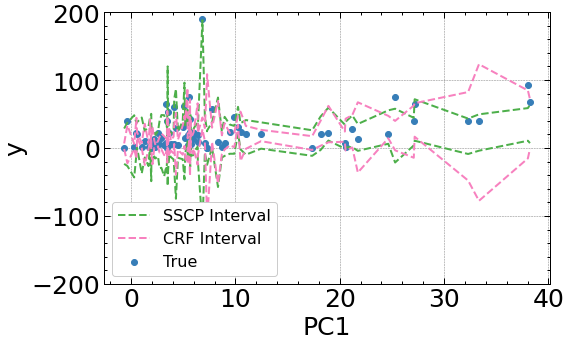

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.style.reload_library()

# set plot parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.style.use(["science",  "no-latex", "notebook", "grid", "vibrant"])

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=20)  # fontsize of the tick labels
plt.rc("ytick", labelsize=20)  # fontsize of the tick labels
plt.rc("legend", fontsize=16)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

FONT=25
plt.rc("font", size=FONT)  # controls default text sizes
# plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=16)  # legend fontsize
plt.rc("figure", titlesize=FONT)  # fontsize of the figure title


n=int(len(X_test_sc)*0.1)
n=75

ids = np.argsort(vime_intervals)[-n:]

pca = PCA(n_components=1)
pca.fit(X_train_sc)
X_train_pca1 = pca.transform(X_train_sc)
X_test_pca1 = pca.transform(X_test_sc)

sortids = np.argsort(X_test_pca1.reshape(-1)[ids])

plt.figure(figsize=(8,5))
plt.plot(X_test_pca1.reshape(-1)[ids][sortids], vime_upper.reshape(-1)[ids][sortids], color='#4DAF4A', label='SSCP Interval', linestyle='--')
plt.plot(X_test_pca1.reshape(-1)[ids][sortids], cfr_upper.reshape(-1)[ids][sortids], color='#F781BF', label='CRF Interval', linestyle='--')

plt.plot(X_test_pca1.reshape(-1)[ids][sortids], vime_lower.reshape(-1)[ids][sortids], color='#4DAF4A', linestyle='--')
plt.plot(X_test_pca1.reshape(-1)[ids][sortids], cfr_lower.reshape(-1)[ids][sortids], color='#F781BF', linestyle='--')

plt.scatter(X_test_pca1.reshape(-1)[ids], y_test_sc.reshape(-1)[ids], color='#377EB8', label='True')
plt.legend(loc=3)
plt.ylim(-200,200)
plt.xlabel('PC1')
plt.ylabel('y')
plt.savefig('../figures/intervals_fb.pdf')